## HomeWork 3: Unemployement

Unemployment rates represent unemployed persons as a percentage of the labour force. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who were: a. without work during the reference week, b. currently available for work, i.e. were available for paid employment or self-employment before the end of the two weeks following the reference week, c. actively seeking work, i.e. had taken specific steps in the four weeks period ending with the reference week to seek paid employment or self-employment or who found a job to start later, i.e. within a period of, at most, three months.

In [31]:
import os
import pandas as pd
import json
import folium
import branca.colormap as cm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

### Europe Unemployement

In [32]:
# Loading the european map
country_geo_path = r'./topojson/europe.topojson.json'
topo_json_data = json.load(open(country_geo_path))

In [33]:
# Loading the unemployement data set and selecting the interesting columns
unemployement_data_file=r'Eurostat_Table_unemployement.xls'
unemployement_data=pd.read_excel(unemployement_data_file,skiprows=3)
unemployement_data_2016=pd.concat([unemployement_data['geo\\time'][0:38], unemployement_data['2016'][0:38]], axis=1)
unemployement_data_2016.rename(columns={'geo\\time': 'Country', '2016': 'UnemployementRate'}, inplace=True)

#delete row with switerland and unvalid value: could be add later if needed

unemployement_data_2016=unemployement_data_2016[unemployement_data_2016['UnemployementRate'] != ':']
unemployement_data_2016=unemployement_data_2016.apply(pd.to_numeric, errors='ignore')
unemployement_data_2016=unemployement_data_2016[4:]
display(unemployement_data_2016.head())

,Country,UnemployementRate
4,Belgium,7.8
5,Bulgaria,7.6
6,Czech Republic,4.0
7,Denmark,6.2
8,Germany,4.1


graph des quantiles: à définir si on garde 
-rajouter legende et autres

## Spliting data set decision

Here we wanted to see which splitting rule we had to choose in order to represent the unemployment in Europe in an optimal way. Our first idea was to use the standard quantiles, i.e. 25%, 50% 75% 100%. With this method we were not satisfied, indeed we would like to have a "threshold" that split our data in groups that have similar unemployment rate. Looking at the first bar plot, we don't really see a difference between the 15th country and the 20th country. Unsatisfied, we decide to create a splitting criterion, which is more related to the health of a country. A country with less than 5% of unemployment is a country in a good shape. Between 5% and 9% is ok, then between 9% and 13% are countries that should care about the situation and improve. More than 13% countries with real problems. Thus we found the quantiles that fit our scale. When looking at the second bar plot, we believe groups are best distributed related to the unemployment. This scale is the one we will use for the map plot.

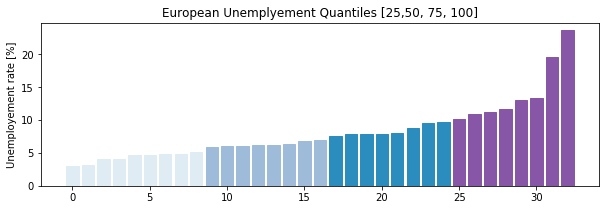

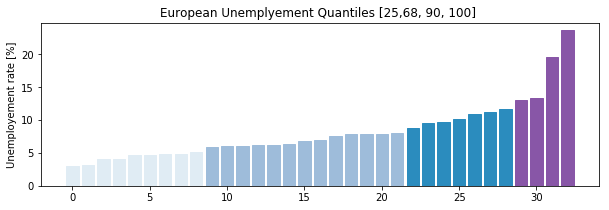

In [68]:
fig = plt.gcf()
fig.set_size_inches(10, 3)

quantiles = np.percentile(unemployement_data_2016['UnemployementRate'],[25,50, 75, 100])
sortedEl = unemployement_data_2016['UnemployementRate'].sort_values()
barlist=plt.bar(np.arange(len(sortedEl)) , sortedEl.iloc[np.arange(len(sortedEl))])
color = ['#e0ecf4','#9ebcda','#2b8cbe','#8856a7']

for q,j in enumerate (quantiles):
    
    for i in np.where(sortedEl <= quantiles[3-q])[0]:
        barlist[i].set_color(color[3-q])
plt.ylabel('Unemployement rate [%]')
plt.title('European Unemplyement Quantiles [25,50, 75, 100]')
     
plt.show()


fig = plt.gcf()
fig.set_size_inches(10, 3)

quantiles = np.percentile(unemployement_data_2016['UnemployementRate'],[25,68, 90, 100])
sortedEl = unemployement_data_2016['UnemployementRate'].sort_values()
barlist=plt.bar(np.arange(len(sortedEl)) , sortedEl.iloc[np.arange(len(sortedEl))])
color = ['#e0ecf4','#9ebcda','#2b8cbe','#8856a7']

for q,j in enumerate (quantiles):
    
    for i in np.where(sortedEl <= quantiles[3-q])[0]:
        barlist[i].set_color(color[3-q])
plt.ylabel('Unemployement rate [%]')
plt.title('European Unemplyement Quantiles [25,68, 90, 100] ')
     
plt.show()


#### Function to color map 

The next step was to select a set of colors that express well the health of a country. We decide to use a linear scale going from the color green, which express friendliness to red which expresses danger.

In [69]:
colormap = cm.linear.YlGn.scale(
    unemployement_data_2016['UnemployementRate'].min(),
    unemployement_data_2016['UnemployementRate'].max())

unemployment_dict = unemployement_data_2016.set_index('Country')['UnemployementRate']

linear = cm.LinearColormap(['green','yellow','red'], vmin=3., vmax=10.)

final=linear.to_step(
               data=unemployement_data_2016['UnemployementRate'],
               method='quantiles',
               quantiles=[0, 0.25,0.68, 0.9, 1],
               round_method='int')

we chose color that directly tells us if it's good or bad (green and red)

In [70]:
def mycolor(pays):
    if unemployment_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=final(unemployment_dict[pays])
        return color

In [71]:
eu_map= folium.Map([48,15], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(topo_json_data,'objects.europe',
    style_function=lambda feature: {
        'fillColor': mycolor(feature['properties']['NAME']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(eu_map)
final.caption = 'A colormap caption'
eu_map.add_child(final)
eu_map

### Switzerland

In [14]:
canton_geo_path = r'./topojson/ch-cantons.topojson.json'
topo_json_dataSwiss = json.load(open(canton_geo_path))

m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons').add_to(m_swiss)

We noticed that the name of the cantons in the file that we get from the website are with their respective language name. Luckily, in this case we noticed as well that the order of the topo for the cantons is the same as the xlsx file. So we just mapped "linearly" the cantons name in the topoJson with the unemployement rate from the data set.

In [15]:
topocantons = []
for i in range(26):
    topocantons.append(topo_json_dataSwiss['objects']['cantons']['geometries'][i]['properties']['name'])
cantonS = pd.Series(topocantons)

In [16]:
cantonS=cantonS.append(pd.Series(['Total']),ignore_index=True)

We get the data for 2016 to have the same year as for Europe and then we compute the average over the 12 months for the "Chômage" and "Demandeur d'emplois".

As we noticed, the site does not give the actual rate for "Demandeur d'emplois but only the number of people. From the number of people of the "Chômage" and its rate we got the total active population that helps us to get the rate for "Demandeur d'emplois"

In [17]:
unemployement_data_file_suisse=r'Taux_suisse_2016.xlsx'
unemployement_data=pd.read_excel(unemployement_data_file_suisse,skiprows=3)
#display(unemployement_data.head())
unemployement_data_suisse=pd.concat([unemployement_data['Unnamed: 0'], unemployement_data['Taux de chômage.12'],unemployement_data["Chômeurs inscrits.12"],unemployement_data["Demandeurs d'emploi.12"]], axis=1)

unemployement_data_suisse['Canton Names'] = cantonS
unemployement_data_suisse['Demandeurs d\'emploi.12']=unemployement_data_suisse['Demandeurs d\'emploi.12']/12
unemployement_data_suisse['Chômeurs inscrits.12']=unemployement_data_suisse['Chômeurs inscrits.12']/12

unemployement_data_suisse['Population active']=100*unemployement_data_suisse['Chômeurs inscrits.12']/unemployement_data_suisse['Taux de chômage.12']
unemployement_data_suisse["Taux Demandeur d'emplois"]=unemployement_data_suisse['Demandeurs d\'emploi.12']/unemployement_data_suisse['Population active']*100


cols = list(unemployement_data_suisse)
cols.pop(cols.index("Unnamed: 0"))
cols.insert(0, cols.pop(cols.index("Canton Names")))
cols.insert(2, cols.pop(cols.index("Taux Demandeur d'emplois")))
unemployement_data_suisse = unemployement_data_suisse.loc[:, cols]
unemployement_data_suisse.rename(columns={'Taux de chômage.12': 'Taux de chômage', 'Chômeurs inscrits.12': 'Chômeurs inscrits',"Demandeurs d'emploi.12":"Demandeurs d'emploi"}, inplace=True)
display(unemployement_data_suisse.head(5))
chomage_swiss_dict = unemployement_data_suisse.set_index('Canton Names')['Taux de chômage']
demandeur_swiss_dict = unemployement_data_suisse.set_index('Canton Names')["Taux Demandeur d'emplois"]


,Canton Names,Taux de chômage,Taux Demandeur d'emplois,Chômeurs inscrits,Demandeurs d'emploi,Population active
0,Zürich,3.7,4.524274,30083.916667,36785.916667,813078.828829
1,Bern/Berne,2.7,3.548183,15283.166667,20084.250000,566043.209877
2,Luzern,2.1,3.407361,4601.750000,7466.583333,219130.952381
3,Uri,1.0,1.803557,201.500000,363.416667,20150.000000
4,Schwyz,1.8,2.681069,1537.166667,2289.583333,85398.148148


Now we need to choose a good colormap that suits both.
We used a simple linear colormap between green and yellow. The same reason than for the European map, green is a friendly color, that suit well to cantons or countries with a low unemployment rate. Yellow is more an alarming color that fits well to cantons with the highest unemployment rate. We decided to use yellow and not red to be coherent with the European map, indeed in Switzerland there is no cantons with an unemployment rate as high as the majority of the European countries, thus it would not be correct to use the red color for the worst cantons.

In [72]:
max_employement=unemployement_data_suisse["Taux Demandeur d'emplois"].max()
#print(unemployement_data_suisse['Taux de chômage'].min())
linear2 = cm.LinearColormap(['green','yellow'], vmin=0, vmax=max_employement)
def mycolor2(pays):
    if chomage_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=linear2(chomage_swiss_dict[pays])
        return color
def mycolor3(pays):
    if demandeur_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=linear2(demandeur_swiss_dict[pays])
        return color

## Now we plot the rate of all the people looking for a job in Switzerland


In [73]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor3(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
linear2.caption = 'A colormap caption'
m_swiss.add_child(linear2)
m_swiss

## For Only Unemployed people with no job we get a much "greener map".

In [20]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor2(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
linear2.caption = 'A colormap caption'
m_swiss.add_child(linear2)
m_swiss

Now we can Redo the maps with a different color mapping. Exemple step color

In [74]:
final2=linear2.to_step(
               method='linear',
               index=[0,3,4,6, max_employement],
                round_method=None)
               #quantiles=[0, 0.33,0.50, 1]) for reustigraben

## Nationality Unemployement Rate in Switzerland

In [22]:
topocantons = []
for i in range(26):
    topocantons.append(topo_json_dataSwiss['objects']['cantons']['geometries'][i]['properties']['name'])
cantonS = pd.Series(topocantons)

In [23]:
unemployement_data_file_suisseI=r'TauxdechômageNationalitées.xlsx'
unemployement_dataS=pd.read_excel(unemployement_data_file_suisseI,skiprows=3, usecols = [0,1,51])
unemployement_dataS = unemployement_dataS.set_index('Unnamed: 1')
swiss = {'Canton': cantonS.tolist(), 'Taux de Chômage Suisses': unemployement_dataS.loc[['Suisses'], 'Taux de chômage.12'].tolist()}
swissswiss = pd.DataFrame(data=swiss)
etranger = {'Canton': cantonS.tolist(), 'Taux de Chômage Etranger': unemployement_dataS.loc[['Etrangers'], 'Taux de chômage.12'].tolist()}
swissFor = pd.DataFrame(data=etranger)

display(swissswiss.head(5))
display(swissFor.head(5))

,Canton,Taux de Chômage Suisses
0,Zürich,2.8
1,Bern/Berne,2.0
2,Luzern,1.5
3,Uri,0.6
4,Schwyz,1.2


,Canton,Taux de Chômage Etranger
0,Zürich,6.0
1,Bern/Berne,6.5
2,Luzern,4.7
3,Uri,4.2
4,Schwyz,3.9


In [24]:
unemployment_Etranger_dict = swissFor.set_index('Canton')['Taux de Chômage Etranger']
unemployment_Swiss_dict = swissswiss.set_index('Canton')['Taux de Chômage Suisses']

In [25]:
unemployment_Etranger_dict

Canton
Zürich                     6.0
Bern/Berne                 6.5
Luzern                     4.7
Uri                        4.2
Schwyz                     3.9
Obwalden                   3.0
Nidwalden                  3.1
Glarus                     4.9
Zug                        4.0
Fribourg                   5.8
Solothurn                  5.9
Basel-Stadt                5.3
Basel-Landschaft           5.4
Schaffhausen               6.4
Appenzell Ausserrhoden     3.9
Appenzell Innerrhoden      3.9
St. Gallen                 5.1
Graubünden/Grigioni        4.6
Aargau                     6.2
Thurgau                    4.9
Ticino                     5.4
Vaud                       6.8
Valais/Wallis              8.2
Neuchâtel                  9.1
Genève                     6.3
Jura                      10.6
Name: Taux de Chômage Etranger, dtype: float64

In [ ]:
def mycolor_swiss(pays):
    if unemployment_Swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=step_color(unemployment_Swiss_dict[pays])
        return color
    
def mycolor_etranger(pays):
    if unemployment_Etranger_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=step_color(unemployment_Etranger_dict[pays])
        return color

## Swiss unemployed people rate in Switzerland


In [75]:
linear2 = cm.LinearColormap(['green','yellow'], vmin=0, vmax=max_employement)
step_color=linear2.to_step(
               method='linear',
               index=[0,3,7, swissFor['Taux de Chômage Etranger'].max()],
                round_method=None)

m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor_swiss(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
step_color.caption = 'A colormap caption'
m_swiss.add_child(step_color)
m_swiss

## Foreign unemployed people rate in Switzerland

In [27]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor_etranger(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
step_color.caption = 'A colormap caption'
m_swiss.add_child(step_color)
m_swiss

## Analysis:

When looking at both maps, we can see that there is a clear difference between the rate of unemployement whithin swiss and foreign people. Indeed in the first swiss map which represents the swiss people unemployement rate, the colors are almost dark green and a little bit of light green in the french part, while in the second map representing the foreign people unemployement rate, the colors are almost light green and in some part they are yellow. To go further in the analysis we decide to make a map representing the difference of the swiss and foreign people unemployement rate.

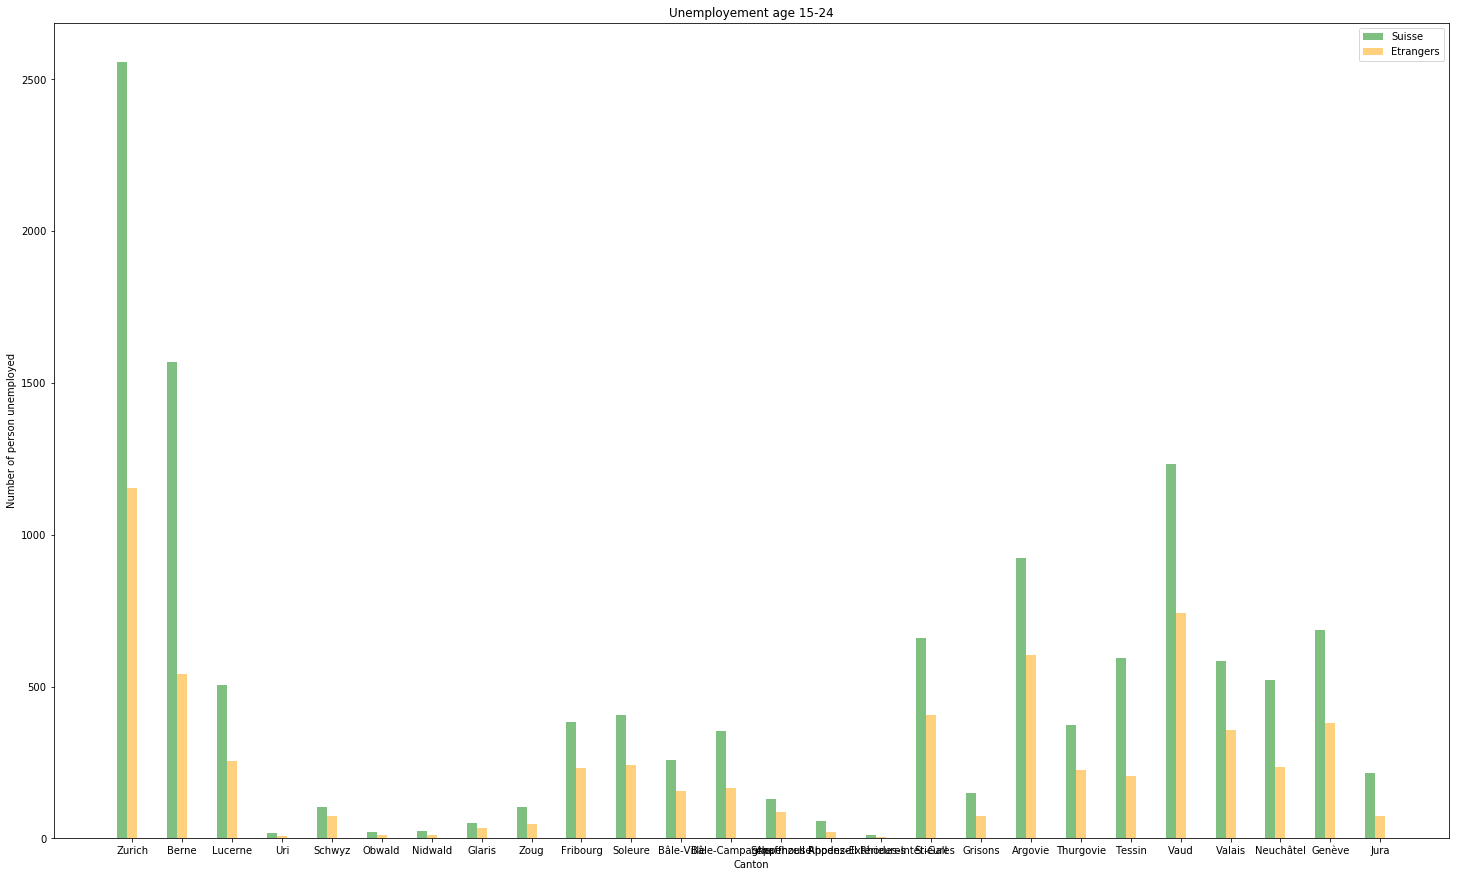

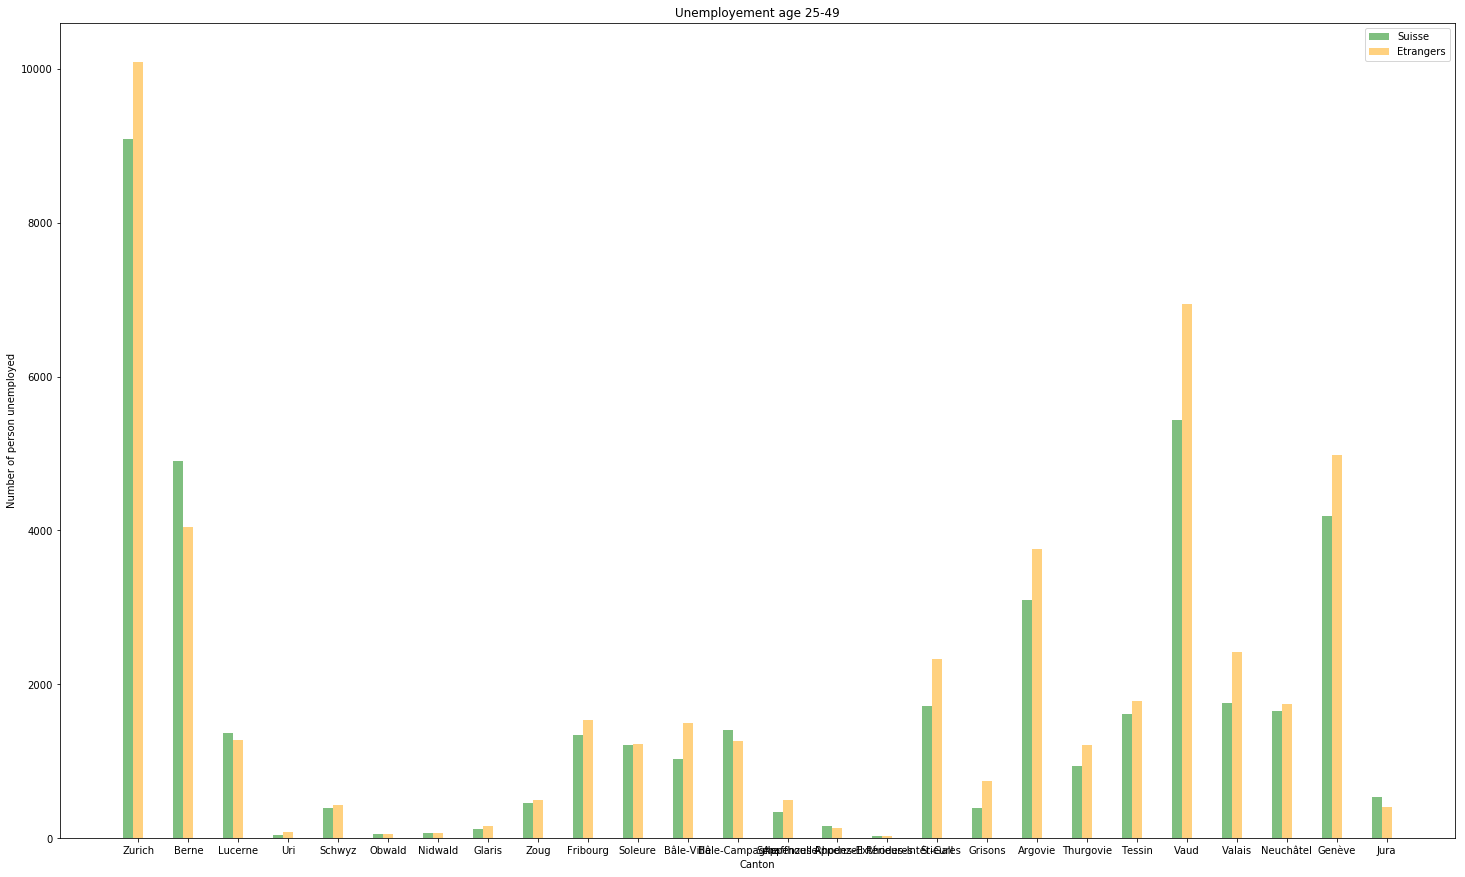

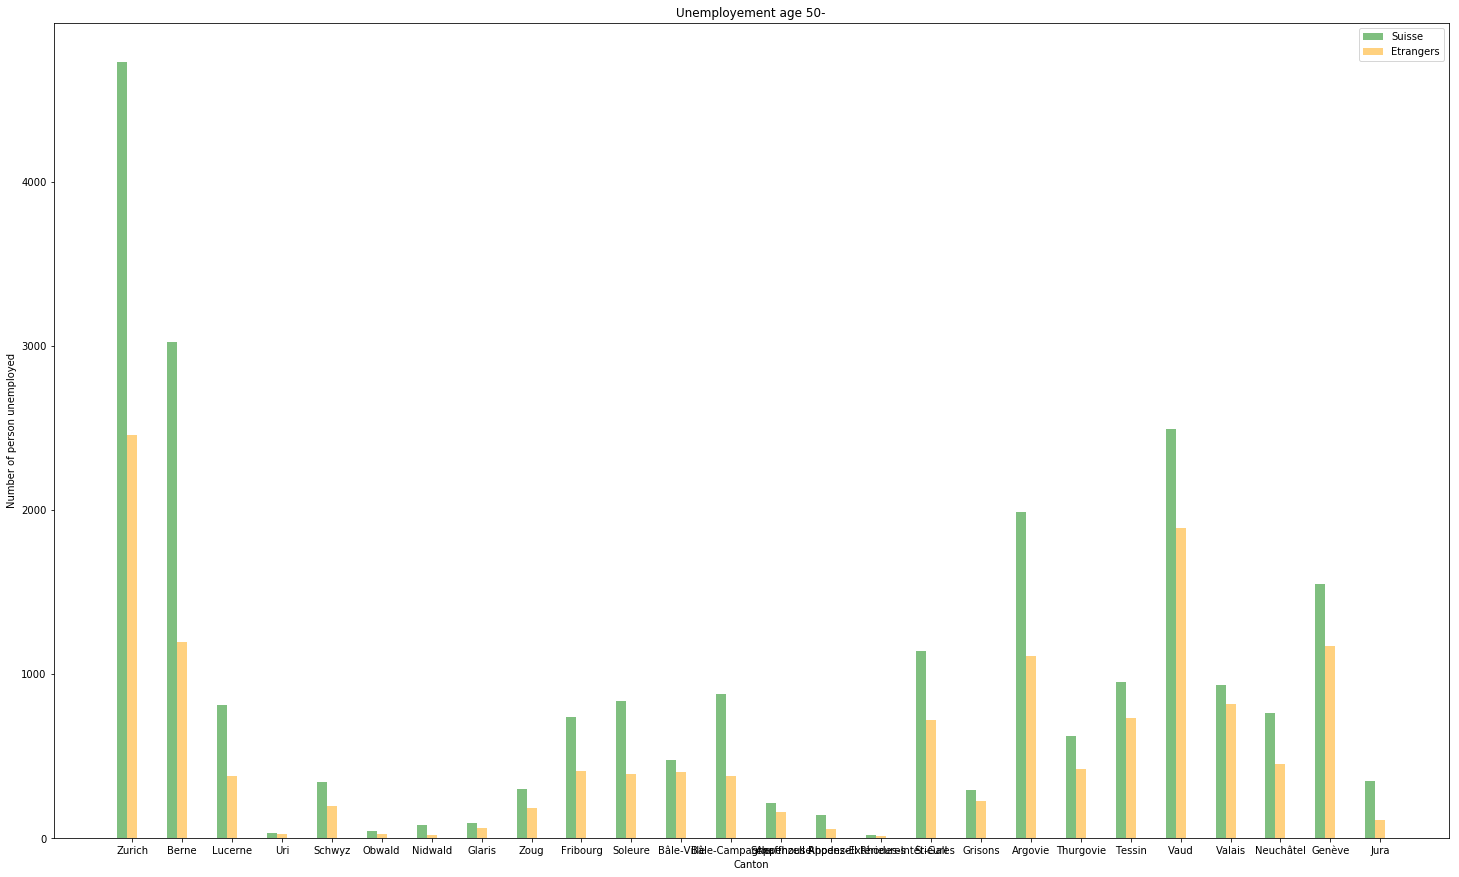

In [28]:
unemployement_data_file_suisse_age=r'Chomeurs_ages_2016.xlsx'
unemployement_data_age=pd.read_excel(unemployement_data_file_suisse_age,skiprows=3, usecols = [0,1,2,17])
unemployement_data_age = unemployement_data_age.set_index('Unnamed: 1')

swiss_15_24 = unemployement_data_age.loc[['Suisses'], 'Moyenne'][0::4].tolist()
swiss_25_49 = unemployement_data_age.loc[['Suisses'], 'Moyenne'][1::4].tolist()
swiss_50_inf = unemployement_data_age.loc[['Suisses'], 'Moyenne'][2::4].tolist()

foreign_15_24 =unemployement_data_age.loc[['Etrangers'], 'Moyenne'][0::4].tolist()
foreign_25_49 = unemployement_data_age.loc[['Etrangers'], 'Moyenne'][1::4].tolist()
foreign_50_inf =unemployement_data_age.loc[['Etrangers'], 'Moyenne'][2::4].tolist()

_, idx = np.unique(unemployement_data_age['Unnamed: 0'].values, return_index=True)
name = unemployement_data_age['Unnamed: 0'].values[np.sort(idx)]

fig = plt.gcf()
fig.set_size_inches(25, 15)

travel = name
bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_15_24,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_15_24 ,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Number of person unemployed')
plt.title('Unemployement age 15-24')
plt.xticks(x +bar_width, travel)

plt.show()


fig = plt.gcf()
fig.set_size_inches(25, 15)

travel = name
bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_25_49,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_25_49 ,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Number of person unemployed')
plt.title('Unemployement age 25-49')
plt.xticks(x +bar_width, travel)

plt.show()

fig = plt.gcf()
fig.set_size_inches(25, 15)

travel = name
bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_50_inf,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_50_inf ,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Number of person unemployed')
plt.title('Unemployement age 50-')
plt.xticks(x +bar_width, travel)

plt.show()

TODO: reusigrabben

In [29]:
#map de base avec ca et ca peut le faire
final2=linear2.to_step(
               method='linear',
               index=[0,3,4,6, max_employement],
                round_method=None)
               #quantiles=[0, 0.33,0.50, 1]) for reustigra